In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import time
import os
import tflearn
from utils import *
os.environ["CUDA_VISIBLE_DEVICES"]='1'


In [2]:
mnist_data = input_data.read_data_sets("MNIST_data", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Residual Network

In [3]:
inputs = tf.placeholder(tf.float32, [None, 28, 28, 1], name='inputs')
targets = tf.placeholder(tf.float32, [None, 2], name='targets')
input_shortcut = tf.placeholder(tf.float32, [None, 2], name='input_shortcut')
train_flag = tf.placeholder(tf.bool, name='training')


net = tflearn.conv_2d(inputs, 64, 3, activation='relu', bias=False)
# Residual blocks
net = tflearn.residual_bottleneck(net, 3, 16, 64)
net = tflearn.residual_bottleneck(net, 1, 32, 128, downsample=True)
net = tflearn.residual_bottleneck(net, 2, 32, 128)
net = tflearn.residual_bottleneck(net, 1, 64, 256, downsample=True)
net = tflearn.residual_bottleneck(net, 2, 64, 256)
net = tflearn.batch_normalization(net)
net = tflearn.activation(net, 'relu')
net = tflearn.global_avg_pool(net)

net = tflearn.fully_connected(net, 200, activation='relu')
feature_transform = tflearn.fully_connected(net, 2, activation='relu')
output = dense_custom(tf.cond(train_flag, lambda: feature_transform,
                              lambda: input_shortcut),
                      2, 2, activation=None)

#This part is for computing the accuracy of this model
pred_y = tf.nn.softmax(output)
pred_y_true = tf.argmax(pred_y, 1)
y_true = tf.argmax(targets, 1)
correct_prediction = tf.equal(pred_y_true, y_true)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# loss function and optimizer
cost = tf.reduce_mean((tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=targets)))

step_momentum = tf.train.MomentumOptimizer(0.0001, 0.9).minimize(cost)

all_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
last_layer_variables = filter(lambda x: 'Variable' in x.name, all_variables)
previous_layer_variables = filter(lambda x: 'Variable' not in x.name, all_variables)

step_sgd_previous_layer = tf.train.GradientDescentOptimizer(0.0001).minimize(cost,
                        var_list = previous_layer_variables)

optimizer_sgd_last_layer = tf.train.GradientDescentOptimizer(1e-4)
step_sgd_last_layer = optimizer_sgd_last_layer.minimize(cost,
                        var_list = last_layer_variables)
optimizer_m_last_layer = tf.train.MomentumOptimizer(1e-4, 0.9)
step_m_last_layer = optimizer_m_last_layer.minimize(cost,
                        var_list = last_layer_variables)


# optimizer = tf.train.MomentumOptimizer(0.0001, 0.9).minimize(cost)
saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES))

In [4]:
config = tf.ConfigProto()
config.log_device_placement=False
config.allow_soft_placement=True
config.gpu_options.allow_growth=True
session = tf.Session(config=config)
session.run(tf.global_variables_initializer())

# Training helper functions

In [5]:
def get_2_class(imgs, labs):
    label = np.argmax(labs,1)
    index_0 = np.where(label==0)[0]
    index_1 = np.where(label==1)[0]
    index = list(index_0)+list(index_1)
    images = imgs[index]
    label = label[index]
    label = to_categorical(label, 2)
    return images, label

In [7]:
batch_size = 4096
def optmizer(optimizer_step, epochs):

    for i in (range(epochs)):
        epoch_loss = []
        start_epoch = time.time()
        for ii in range(mnist_data.train.num_examples//batch_size):
            batch = mnist_data.train.next_batch(batch_size)
            imgs = batch[0].reshape((-1, 28, 28, 1))
            labs = batch[1]
            imgs, labs = get_2_class(imgs, labs)

            dict_input = {inputs:imgs, targets:labs, train_flag: True, 
                         input_shortcut: np.zeros([batch_size, 2])}

            c, _ = session.run([cost, optimizer_step], feed_dict=dict_input)
            epoch_loss.append(c)
        print("Epoche: {}/{}".format(i+1, epochs), "| Training accuracy: ", session.run(accuracy, feed_dict=dict_input), 
              "| Cost: {}".format(np.mean(epoch_loss)), " | Time for epoch: {:.2f}s".format(time.time() - start_epoch))
        if i%100==0:
            saver.save(session,'../model/mnist_resnet_{}.ckpt'.format(i))

In [8]:
# reintialize the last layer
saver.restore(session,'../model/mnist_resnet_900.ckpt')
session.run(tf.variables_initializer(last_layer_variables))

# Train and check

In [ ]:
optmizer(step_m_last_layer, 3000)

('Epoche: 1/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0417444370687', ' | Time for epoch: 1.10s')
('Epoche: 2/3000', '| Training accuracy: ', 1.0, '| Cost: 0.041651442647', ' | Time for epoch: 1.07s')
('Epoche: 3/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0417934656143', ' | Time for epoch: 1.08s')
('Epoche: 4/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0415831208229', ' | Time for epoch: 1.10s')
('Epoche: 5/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0416099876165', ' | Time for epoch: 1.08s')
('Epoche: 6/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0415505319834', ' | Time for epoch: 1.09s')
('Epoche: 7/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0415805764496', ' | Time for epoch: 1.09s')
('Epoche: 8/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0413205847144', ' | Time for epoch: 1.07s')
('Epoche: 9/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0414415076375', ' | Time for epoch: 1.09s')
('Epoche: 10/3000', '| Training a

('Epoche: 77/3000', '| Training accuracy: ', 0.99881935, '| Cost: 0.0389287211001', ' | Time for epoch: 1.12s')
('Epoche: 78/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0389289073646', ' | Time for epoch: 1.12s')
('Epoche: 79/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0386991091073', ' | Time for epoch: 1.12s')
('Epoche: 80/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0387671217322', ' | Time for epoch: 1.12s')
('Epoche: 81/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0386385470629', ' | Time for epoch: 1.11s')
('Epoche: 82/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0385217927396', ' | Time for epoch: 1.09s')
('Epoche: 83/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0386040844023', ' | Time for epoch: 1.11s')
('Epoche: 84/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0385036394', ' | Time for epoch: 1.11s')
('Epoche: 85/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0385273844004', ' | Time for epoch: 1.12s')
('Epoche: 86/3000', '| Tra

('Epoche: 153/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0363608561456', ' | Time for epoch: 1.14s')
('Epoche: 154/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0362595617771', ' | Time for epoch: 1.12s')
('Epoche: 155/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0360969230533', ' | Time for epoch: 1.11s')
('Epoche: 156/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0359527803957', ' | Time for epoch: 1.11s')
('Epoche: 157/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0361467003822', ' | Time for epoch: 1.11s')
('Epoche: 158/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0360805764794', ' | Time for epoch: 1.11s')
('Epoche: 159/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0361752659082', ' | Time for epoch: 1.12s')
('Epoche: 160/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.035975869745', ' | Time for epoch: 1.11s')
('Epoche: 161/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0360542982817', ' | Time for epoch: 1.11s')
('Epoche: 1

('Epoche: 228/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0340238288045', ' | Time for epoch: 1.12s')
('Epoche: 229/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0339484475553', ' | Time for epoch: 1.12s')
('Epoche: 230/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0339040979743', ' | Time for epoch: 1.12s')
('Epoche: 231/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0339902155101', ' | Time for epoch: 1.11s')
('Epoche: 232/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0336542092264', ' | Time for epoch: 1.10s')
('Epoche: 233/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0339204631746', ' | Time for epoch: 1.11s')
('Epoche: 234/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0338549315929', ' | Time for epoch: 1.12s')
('Epoche: 235/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0338899753988', ' | Time for epoch: 1.11s')
('Epoche: 236/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.033765271306', ' | Time for epoch: 1.11s')
('Epoche: 237/3000', 

('Epoche: 304/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0320823006332', ' | Time for epoch: 1.12s')
('Epoche: 305/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0318136774004', ' | Time for epoch: 1.13s')
('Epoche: 306/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0320070795715', ' | Time for epoch: 1.11s')
('Epoche: 307/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0320109054446', ' | Time for epoch: 1.11s')
('Epoche: 308/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0320095568895', ' | Time for epoch: 1.11s')
('Epoche: 309/3000', '| Training accuracy: ', 1.0, '| Cost: 0.031949069351', ' | Time for epoch: 1.11s')
('Epoche: 310/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0319343395531', ' | Time for epoch: 1.12s')
('Epoche: 311/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0319549031556', ' | Time for epoch: 1.13s')
('Epoche: 312/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0318078435957', ' | Time for epoch: 1.12s')
('Epoche: 313/3

('Epoche: 379/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0302765369415', ' | Time for epoch: 1.11s')
('Epoche: 380/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0302302129567', ' | Time for epoch: 1.11s')
('Epoche: 381/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0303107332438', ' | Time for epoch: 1.12s')
('Epoche: 382/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.030313340947', ' | Time for epoch: 1.11s')
('Epoche: 383/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0303042624146', ' | Time for epoch: 1.11s')
('Epoche: 384/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0301617123187', ' | Time for epoch: 1.11s')
('Epoche: 385/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0302240084857', ' | Time for epoch: 1.44s')
('Epoche: 386/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0301216207445', ' | Time for epoch: 1.12s')
('Epoche: 387/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0301576573402', ' | Time for epoch: 1.11s')
('Epoche

('Epoche: 455/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0287551544607', ' | Time for epoch: 1.10s')
('Epoche: 456/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0286194998771', ' | Time for epoch: 1.11s')
('Epoche: 457/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.0286235585809', ' | Time for epoch: 1.10s')
('Epoche: 458/3000', '| Training accuracy: ', 0.9999999, '| Cost: 0.0287014413625', ' | Time for epoch: 1.07s')
('Epoche: 459/3000', '| Training accuracy: ', 0.9988385, '| Cost: 0.0285811442882', ' | Time for epoch: 1.10s')
('Epoche: 460/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0285219885409', ' | Time for epoch: 1.12s')
('Epoche: 461/3000', '| Training accuracy: ', 0.99999994, '| Cost: 0.0286275167018', ' | Time for epoch: 1.11s')
('Epoche: 462/3000', '| Training accuracy: ', 1.0, '| Cost: 0.0286116190255', ' | Time for epoch: 1.11s')
('Epoche: 463/3000', '| Training accuracy: ', 1.0000001, '| Cost: 0.028499873355', ' | Time for epoch: 1.10s')
('Epoche: 

In [10]:
def plot_temp(feature, label, name=None):
	pylab.figure()
	red = feature[label == 0]
	blue = feature[label == 1]
	pylab.plot(red[:, 0], red[:, 1], 'g.')
	pylab.plot(blue[:, 0], blue[:, 1], 'k.')
	pylab.xticks(fontsize=17)
	pylab.yticks(fontsize=17)
	pylab.show()

def plot_temp_all(feature, label, feature_t, label_t, 
	name=None):
	pylab.figure()
	red = feature[label == 0]
	blue = feature[label == 1]
	green = feature_t[label_t == 0]
	black = feature_t[label_t == 1]
	pylab.plot(red[:, 0], red[:, 1], 'r.')
	pylab.plot(blue[:, 0], blue[:, 1], 'b.')
	pylab.plot(green[:, 0], green[:, 1], 'g.')
	pylab.plot(black[:, 0], black[:, 1], 'k.')
	pylab.xticks(fontsize=17)
	pylab.yticks(fontsize=17)
	pylab.show()


def random_points(start_x, end_x, start_y, end_y, size, random_state):
	np.random.seed(random_state)
	x1 = np.random.uniform(start_x, end_x, size)
	x2 = np.random.uniform(start_y, end_y, size)
	feature =  np.vstack([x1,x2]).transpose()
	label = np.random.choice(2,size)
	return feature, label

In [13]:
batch_size_test = 4096
# def get_transform_feature():
feature_t = []
label_t = []
for ii in range(mnist_data.train.num_examples//batch_size_test):
    batch = mnist_data.train.next_batch(batch_size_test)
    imgs = batch[0].reshape((-1, 28, 28, 1))
    labs = batch[1]
    imgs, labs = get_2_class(imgs, labs)
    label_t.append(labs)
    feature_t.append(
        session.run(feature_transform, 
                    feed_dict={inputs:imgs, targets:labs, 
                               train_flag: True, 
                               input_shortcut: np.zeros([batch_size, 2])}))
label_t = np.concatenate(label_t, 0)
label_t = np.argmax(label_t, 1)
feature_t = np.concatenate(feature_t, 0)


In [14]:
feature_random, label_random = random_points(-100,
    1300,-100,600, 30000,
    random_state=100)
label_random = to_categorical(label_random, 2)
pre_label_nn= session.run(
    pred_y_true,
    feed_dict={inputs:imgs, 
               targets:label_random,
               train_flag: False, 
               input_shortcut: feature_random})

clf = get_svm(feature_t, label_t)
pre_label_svm = clf.predict(feature_random)

# plot_blobs(feature, label,
#     '../result/exploration/Training_data.png')
# plot_blobs_all_together(feature_random_transform, pre_label_svm,
#     feature_transform, label,
#     '../result/exploration/SVM_decision_boundary_transform.png')
# plot_blobs_all_together(feature_random_transform, pre_label_nn,
#     feature_transform, label,
#     '../result/exploration/NN_decision_boundary_transform.png')
# boundary_overlay(feature_random_transform, pre_label_nn,
#     feature_random_transform, pre_label_svm,
#     '../result/exploration/Decision_boundary_overlay_transform.png')

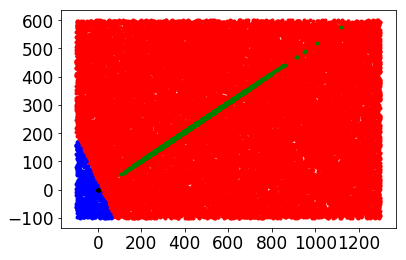

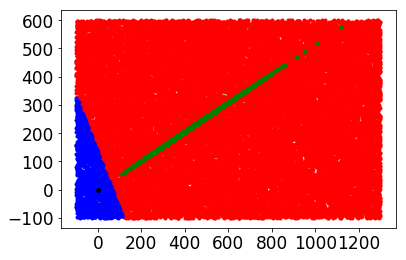

In [15]:
# 1000 epoch
plot_temp_all(feature_random, pre_label_nn,feature_t, label_t)
plot_temp_all(feature_random, pre_label_svm,feature_t, label_t)

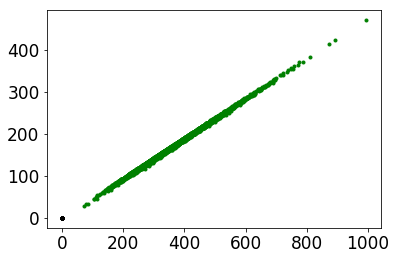

In [14]:
plot_temp(feature_t, label_t)

In [69]:
	plot_blobs_all_together(feature_random, pre_label_nn,feature_t, label_t,
		'../result/exploration/NN_decision_boundary_transform.png')
	plot_blobs_all_together(feature_random, pre_label_svm,feature_t, label_t,
		'../result/exploration/SVM_decision_boundary_transform.png')

In [29]:
def adam_variables_initializer(adam_opt, var_list):
    adam_vars = [adam_opt.get_slot(var, name)
                 for name in adam_opt.get_slot_names()
                 for var in var_list if var is not None]
    adam_vars.extend(list(adam_opt._get_beta_accumulators()))
    return tf.variables_initializer(adam_vars)

optimizer_sgd_last_layer = tf.train.GradientDescentOptimizer(1e-6)
step_sgd_last_layer = optimizer_sgd_last_layer.minimize(cost,
                        var_list = last_layer_variables)
reset_opt_op = tf.variables_initializer([optimizer_sgd_last_layer.get_slot(var, name) 
                for name in optimizer_sgd_last_layer.get_slot_names() for var in last_layer_variables])
session.run(reset_opt_op)

all_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
last_layer_variables = filter(lambda x: 'Variable' in x.name, all_variables)
previous_layer_variables = filter(lambda x: 'Variable' not in x.name, all_variables)

optimizer_last_layer = tf.train.AdamOptimizer(0.0001)
step_last_layer = optimizer_last_layer.minimize(cost,
                        var_list = last_layer_variables)

reset_opt_vars = adam_variables_initializer(optimizer_last_layer,
                                            last_layer_variables)
session.run(reset_opt_vars)